# KANs with RBFs
Replace B-Splines with Radial Basis Functions. They should be faster to compute.
Following base code is taken from [fast-KAN](https://github.com/ZiyaoLi/fast-kan/blob/master/fastkan/fastkan.py)


In [2]:
# Copyright 2024 Li, Ziyao
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import *

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = False,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve 
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

**Function Fitting**

We will take some interesting test functions from [Wavelet Regression](https://github.com/jseabold/web-site/blob/master/content/notebooks/wavelet-regression-in-python.ipynb) notebook.

The Doppler function is 
$$
f(x) = x(1-x) \sin(\frac{2.1\pi}{x+0.05}) \\
x \sim U[0,1]
$$


device is:  cpu
train input data shape torch.Size([1000, 1])
train label data shape torch.Size([1000, 1])


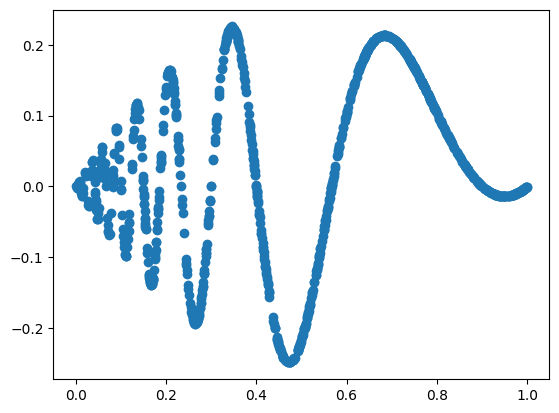

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from kan.utils import create_dataset

torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is: ',device)

f = lambda x: x[:,[0]]*(1-x[:,[0]])*torch.sin((2*np.pi)/(x[:,[0]]+.1))

dataset = create_dataset(f, n_var=1, device=device, ranges=[0,1])

print('train input data shape', dataset['train_input'].shape)
print('train label data shape', dataset['train_label'].shape)

plt.scatter(dataset['train_input'],dataset['train_label'])

In [3]:
# Define model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a KAN: 1D inputs, 1D output, and 5 hidden neurons.
model =FastKAN([1,1,5,5],grid_min=0,grid_max=1,num_grids=5)
model.to(device)

# Define loss
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [4]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        model.train()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()
        
        model.eval()
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")
    return model, train_losses, test_losses



import numpy as np
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)
X_train = dataset['train_input']
y_train = dataset['train_label']
X_test = dataset['test_input']
y_test = dataset['test_label']
mlp, train_losses, test_losses = train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

/opt/miniconda3/envs/ai839/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50/1000, Train Loss: 0.0138, Test Loss: 0.0137
Epoch 100/1000, Train Loss: 0.0074, Test Loss: 0.0070
Epoch 150/1000, Train Loss: 0.0062, Test Loss: 0.0059
Epoch 200/1000, Train Loss: 0.0060, Test Loss: 0.0057
Epoch 250/1000, Train Loss: 0.0059, Test Loss: 0.0057
Epoch 300/1000, Train Loss: 0.0058, Test Loss: 0.0055
Epoch 350/1000, Train Loss: 0.0058, Test Loss: 0.0054
Epoch 400/1000, Train Loss: 0.0058, Test Loss: 0.0054
Epoch 450/1000, Train Loss: 0.0057, Test Loss: 0.0053
Epoch 500/1000, Train Loss: 0.0057, Test Loss: 0.0053
Epoch 550/1000, Train Loss: 0.0057, Test Loss: 0.0053
Epoch 600/1000, Train Loss: 0.0056, Test Loss: 0.0052
Epoch 650/1000, Train Loss: 0.0057, Test Loss: 0.0053
Epoch 700/1000, Train Loss: 0.0059, Test Loss: 0.0053
Epoch 750/1000, Train Loss: 0.0056, Test Loss: 0.0052
Epoch 800/1000, Train Loss: 0.0055, Test Loss: 0.0052
Epoch 850/1000, Train Loss: 0.0055, Test Loss: 0.0051
Epoch 900/1000, Train Loss: 0.0054, Test Loss: 0.0050
Epoch 950/1000, Train Loss: 0

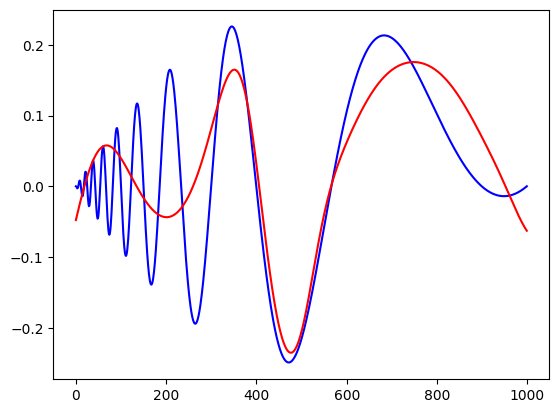

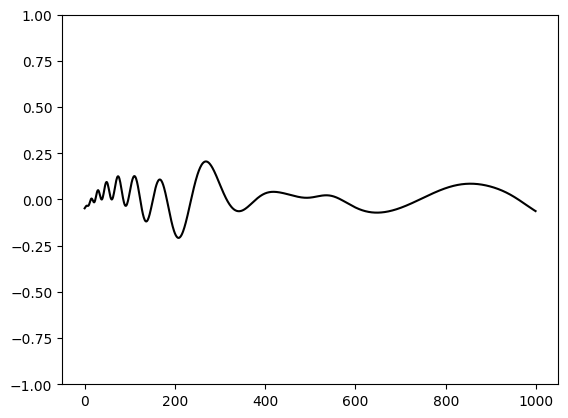

In [5]:
# let us look at the recontruction
X = dataset['train_input']
n  = 1000
X[:,0] = torch.linspace(0,1,steps=n)
y = f(X)
y = y[:,0].detach().numpy()
yh = model.forward(X)

yh = yh[:,0].detach().numpy()
plt.plot(y,color='blue')
plt.plot(yh, color='red')
plt.show()
plt.plot(yh-y, color='black')
plt.ylim(-1,1)
plt.show()